# Next Transaction Prediction: Categorical Convolutional Example

Below example is the same as the previous BinaryToBinary NTP model. It is a model that tries to predict the last transaction in a series. The difference with the previous example is that the input (and also the output) are categorical rather than binary.

----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

# Imports

In [1]:
import torch
import numpy as np
import gc
import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object.

The series we build are 1 item longer than the ones in the encoder examples. The series will be a size of 6 transactions. 5 transactions of which are the input data, 1 transaction, the last will be the label.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

# Derrived Features
date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])
amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_binned
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([learning_features, label])

with en.EnginePandasNumpy(num_threads=8) as e:
    ser_np = e.to_series_stacked(
        learning_features, file, key_feature=customer, time_feature=date_time, window=6, inference=False
    )
    lb_df = e.from_csv(label, file, inference=False)
    lb_np = e.to_numpy_list(label, lb_df)
    data_list = en.NumpyList(ser_np.lists + lb_np.lists)
    
print('Data Shapes')
print(data_list.shapes)
print(data_list.dtype_names)

2021-12-29 15:06:54.889 d373c7.engines.common          INFO     Start Engine...
2021-12-29 15:06:54.889 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-12-29 15:06:54.890 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-12-29 15:06:54.890 d373c7.engines.panda_numpy     INFO     Building Panda for : InternalKeyTime from file ../../../../data/bs140513_032310.csv
2021-12-29 15:06:55.092 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-12-29 15:06:55.093 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-12-29 15:06:55.099 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 7)
2021-12-29 15:06:55.431 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: InternalKeyTime
2021-12-29 15:06:55.437 d373c7.engines.panda_numpy     INFO     Start creating stacked series for Target Tensor Definiti

Data Shapes
[(594643, 6, 5), (594643,)]
['int16', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

For NTP models we perform a 5th step, all fraud records will be removed from the training and validation data. The NTP model will only see *non-fraud* records during training.
> 1. Remove fraud records from training and validation


In [5]:
test_records = 100000
val_records  = 30000
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(model_features, 0)
val_data = val_data.filter_label(model_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del lb_df, ser_np, lb_np, data_list
gc.collect()
print('Done')

Training Data shapes [(429311, 6, 5), (429311,)]
Validation Data shapes [(29670, 6, 5), (29670,)]
Test Data shapes [(100000, 6, 5), (100000,)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2021-12-29 15:07:03.088 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-12-29 15:07:03.116 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-12-29 15:07:03.116 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


## Build the model

> In this example we use a `GeneratedNtp` model, the same model as we used in the 'single' encoder examples. But as we now have series, we can ask it to use the specialised +3-D tensor layers. We're asking it to use 2 convolutional layers. The first layer reduces to __16 features/channels with a kernel_size of 2__, the second layer applies __32 features/channels with a kernel_size of 1__. One further linear layer of size 32 is added between the convolutional layers and the final autoput layer.

In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

m = pm.GeneratedNtp(model_features, convolutional_layers=[(16, 2), (32, 1)], linear_layers=[64])

print(m)

GeneratedNtp(
  Number of parameters : 37187. Loss : MultiLabelNLLLoss,  mean
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
            (2): Embedding(51, 25)
            (3): Embedding(16, 7)
            (4): Embedding(31, 15)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (ntp_conv_body): ConvolutionalNtpBody(
        (conv_layers): Sequential(
          (conv_01): Conv1d(55, 16, kernel_size=(2,), stride=(1,))
          (relu_01): ReLU()
          (conv_02): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
          (relu_02): ReLU()
          (norm_02): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (tail): CategoricalLogSoftmax1d(
    

2021-12-29 15:07:06.507 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 367.96it/s]
2021-12-29 15:07:08.636 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


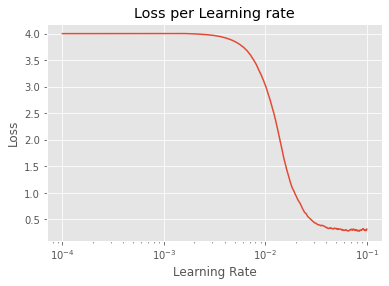

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __5 epochs__ and __learning rate 1e-2__. That means we run over the total training data set a total of 5 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 005/005: 100%|██████████| 3586/3586 [00:07<00:00, 465.02it/s, train_loss=0.236, val_loss=0.235]


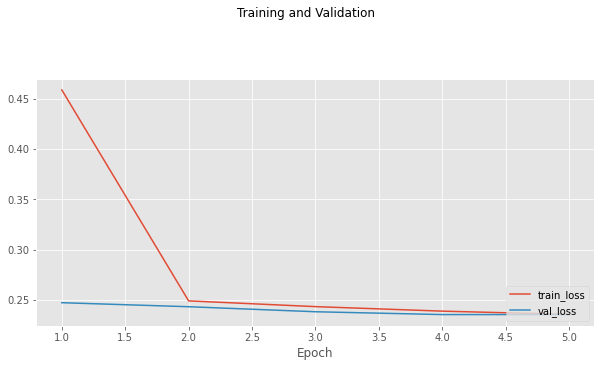

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 1e-2)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> This model preforms fairly similar to the previous 

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1272.69it/s]


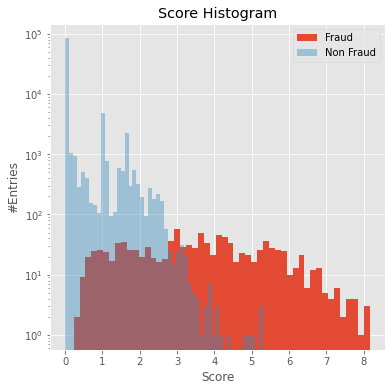

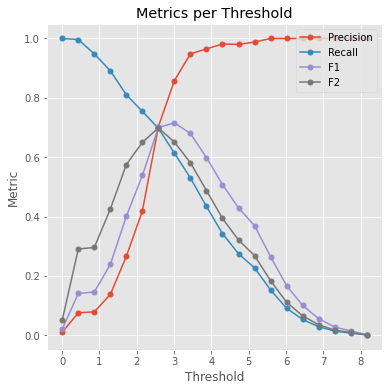

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.82      0.68      0.74      1074

    accuracy                           0.99    100000
   macro avg       0.91      0.84      0.87    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9827
ap score  : 0.7381
-----------------------------------------------------


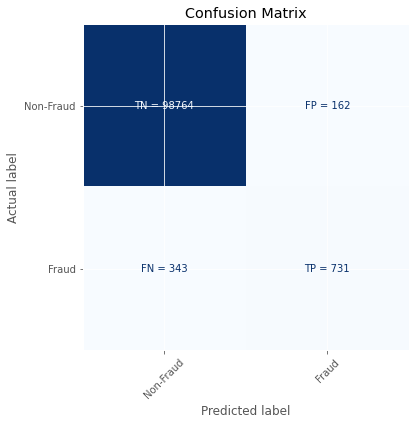

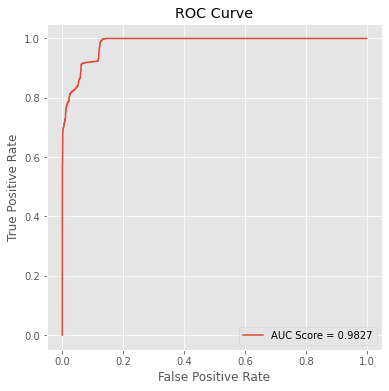

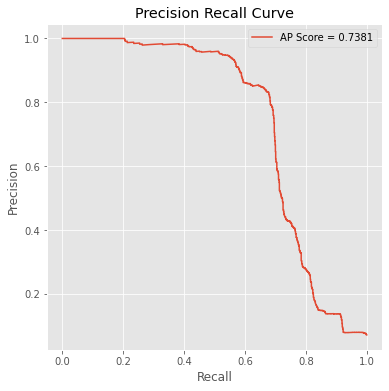

In [10]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=2.75)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=2.75)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

## Plot Embeddings
> Because we now created an embedding (Like in one of the classifier examples) we can visualize it. The plot_embedding method will take the `FeatureIndex` named __category_i__, PCA it and display the 3 principal components. 

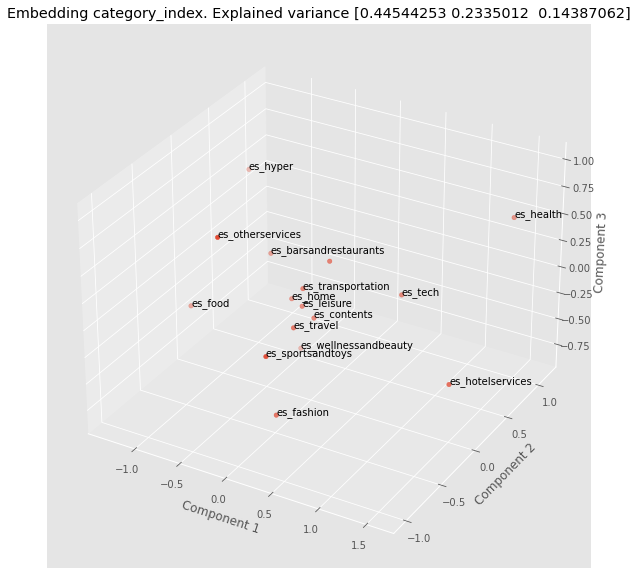

In [11]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))